In [1]:
import os
import json
from pprint import pprint
from copy import deepcopy

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Helper Functions
1. format_name(author)
2. format_affiliation(affiliation)
3. format_authors(authors, with_affiliation=False)
4. format_body(body_text)
5. format_bib(bibs)


In [2]:
def format_name(author):
    middle_name = " ".join(author['middle'])
    
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])


def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []
    
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)
    
    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

Unhide the cell below to find the definition of the following functions:
1. load_files(dirname)
2. generate_clean_df(all_files)

In [3]:
def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)
    
    return raw_files

def generate_clean_df(all_files):
    cleaned_files = []
    
    for file in tqdm(all_files):
        features = [
            file['paper_id'],
            file['metadata']['title'],
            format_authors(file['metadata']['authors']),
            format_authors(file['metadata']['authors'], 
                           with_affiliation=True),
            format_body(file['abstract']),
            format_body(file['body_text']),
            format_bib(file['bib_entries']),
            file['metadata']['authors'],
            file['bib_entries']
        ]

        cleaned_files.append(features)

    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'abstract', 'text', 
                 'bibliography','raw_authors','raw_bibliography']

    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    clean_df.head()
    
    return clean_df

# Biorxviv:Exploration
Let's first take a quick glance at the biorxiv subset of the data. We will also use this opportunity to load all of the json files into a list of nested dictionaries (each dict is an article).

In [4]:
biorxiv_dir = '/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/'
filenames = os.listdir(biorxiv_dir)
print("Number of articles retrieved from biorxiv:", len(filenames))

Number of articles retrieved from biorxiv: 885


In [5]:
all_files = []

for filename in filenames:
    filename = biorxiv_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)

In [6]:
file = all_files[0]
print("Dictionary keys:", file.keys())

Dictionary keys: dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])


# Biroxviv:Abstract


In [7]:
pprint(file['abstract'])

[{'cite_spans': [],
  'ref_spans': [],
  'section': 'Abstract',
  'text': 'Airborne-mediated microbial diseases such as influenza and '
          'tuberculosis represent major public 12 health challenges. A direct '
          'approach to prevent airborne transmission is inactivation of '
          'airborne 13 pathogens, and the airborne antimicrobial potential of '
          'UVC ultraviolet light has long been established; 14 however, its '
          'widespread use in public settings is limited because conventional '
          'UVC light sources are 15 both carcinogenic and cataractogenic. By '
          'contrast, we have previously shown that far-UVC light (207-16 222 '
          'nm) efficiently kills bacteria without harm to exposed mammalian '
          'skin. This is because, due to its 17 strong absorbance in '
          'biological materials, far-UVC light cannot penetrate even the outer '
          '(non living) 18 layers of human skin or eye; however, because '
          

# Biorxviv:Body Text

In [8]:
print("body_text type:", type(file['body_text']))
print("body_text length:", len(file['body_text']))
print("body_text keys:", file['body_text'][0].keys())

body_text type: <class 'list'>
body_text length: 15
body_text keys: dict_keys(['text', 'cite_spans', 'ref_spans', 'section'])


In [9]:
print("body_text content:")
pprint(file['body_text'][:2], depth=3)

body_text content:
[{'cite_spans': [{...}],
  'ref_spans': [],
  'section': '3',
  'text': 'Airborne-mediated microbial diseases represent one of the major '
          'challenges to worldwide public 26 health 1 . Common examples are '
          'influenza 2 , appearing in seasonal 3 and pandemic 4 forms, and '
          'bacterially-27 based airborne-mediated diseases such as '
          'tuberculosis 5 , increasingly emerging in multi-drug resistant 28 '
          'form.'},
 {'cite_spans': [{...}, {...}, {...}, {...}, {...}, {...}, {...}],
  'ref_spans': [],
  'section': '29',
  'text': 'A direct approach to prevent the transmission of airborne-mediated '
          'disease is inactivation of the 30 corresponding airborne pathogens, '
          'and in fact the airborne antimicrobial efficacy of ultraviolet (UV) '
          '31 light has long been established 6-8 . Germicidal UV light can '
          'also efficiently kill both drug-sensitive and 32 '
          'multi-drug-resistant 

In [10]:
texts = [(di['section'], di['text']) for di in file['body_text']]
texts_di = {di['section']: "" for di in file['body_text']}
for section, text in texts:
    texts_di[section] += text

pprint(list(texts_di.keys()))

['3', '29', '49', '67', '74', '101', '106', '140', '171', '255']


In [11]:
body = ""

for section, text in texts_di.items():
    body += section
    body += "\n\n"
    body += text
    body += "\n\n"

print(body[:3000])


3

Airborne-mediated microbial diseases represent one of the major challenges to worldwide public 26 health 1 . Common examples are influenza 2 , appearing in seasonal 3 and pandemic 4 forms, and bacterially-27 based airborne-mediated diseases such as tuberculosis 5 , increasingly emerging in multi-drug resistant 28 form.

29

A direct approach to prevent the transmission of airborne-mediated disease is inactivation of the 30 corresponding airborne pathogens, and in fact the airborne antimicrobial efficacy of ultraviolet (UV) 31 light has long been established 6-8 . Germicidal UV light can also efficiently kill both drug-sensitive and 32 multi-drug-resistant bacteria 9 , as well differing strains of viruses 10 . However, the widespread use of 33 germicidal ultraviolet light in public settings has been very limited because conventional UVC light 34 sources are a human health hazard, being both carcinogenic and cataractogenic 11,12 . 35 By contrast, we have earlier shown that far-UVC lig

In [12]:
print(format_body(file['body_text'])[:3000])

3

Airborne-mediated microbial diseases represent one of the major challenges to worldwide public 26 health 1 . Common examples are influenza 2 , appearing in seasonal 3 and pandemic 4 forms, and bacterially-27 based airborne-mediated diseases such as tuberculosis 5 , increasingly emerging in multi-drug resistant 28 form.

29

A direct approach to prevent the transmission of airborne-mediated disease is inactivation of the 30 corresponding airborne pathogens, and in fact the airborne antimicrobial efficacy of ultraviolet (UV) 31 light has long been established 6-8 . Germicidal UV light can also efficiently kill both drug-sensitive and 32 multi-drug-resistant bacteria 9 , as well differing strains of viruses 10 . However, the widespread use of 33 germicidal ultraviolet light in public settings has been very limited because conventional UVC light 34 sources are a human health hazard, being both carcinogenic and cataractogenic 11,12 . 35 By contrast, we have earlier shown that far-UVC lig

# Biorxviv:Metadata

In [13]:
print(all_files[0]['metadata'].keys())

dict_keys(['title', 'authors'])


In [14]:
print(all_files[0]['metadata']['title'])

Far-UVC light: A new tool to control the spread of airborne-mediated microbial 1 diseases 2


In [15]:
authors = all_files[0]['metadata']['authors']
pprint(authors[:3])

[{'affiliation': {'institution': 'Columbia University Medical Center',
                  'laboratory': '',
                  'location': {'postCode': '10032',
                               'region': 'New York',
                               'settlement': 'New York'}},
  'email': '',
  'first': 'David',
  'last': 'Welch',
  'middle': [],
  'suffix': ''},
 {'affiliation': {'institution': 'Columbia University Medical Center',
                  'laboratory': '',
                  'location': {'postCode': '10032',
                               'region': 'New York',
                               'settlement': 'New York'}},
  'email': '',
  'first': 'Manuela',
  'last': 'Buonanno',
  'middle': [],
  'suffix': ''},
 {'affiliation': {'institution': 'Columbia University Medical Center',
                  'laboratory': '',
                  'location': {'postCode': '10032',
                               'region': 'New York',
                               'settlement': 'New York'}},
  'email

In [16]:
for author in authors:
    print("Name:", format_name(author))
    print("Affiliation:", format_affiliation(author['affiliation']))
    print()


Name: David Welch
Affiliation: Columbia University Medical Center, 10032, New York, New York

Name: Manuela Buonanno
Affiliation: Columbia University Medical Center, 10032, New York, New York

Name: Veljko Grilj
Affiliation: Columbia University Medical Center, 10032, New York, New York

Name: Igor Shuryak
Affiliation: Columbia University Medical Center, 10032, New York, New York

Name: Connor Crickmore
Affiliation: Columbia University Medical Center, 10032, New York, New York

Name: Alan W Bigelow
Affiliation: Columbia University Medical Center, 10032, New York, New York

Name: Gerhard Randers-Pehrson
Affiliation: Columbia University Medical Center, 10032, New York, New York

Name: Gary W Johnson
Affiliation: Columbia University Medical Center, 10032, New York, New York

Name: David J Brenner
Affiliation: Columbia University Medical Center, 10032, New York, New York



In [17]:
pprint(all_files[4]['metadata'], depth=4)

{'authors': [{'affiliation': {'institution': 'Harvard T.H. Chan School of '
                                             'Public Health',
                              'laboratory': '',
                              'location': {...}},
              'email': '',
              'first': 'Corey',
              'last': 'Peak',
              'middle': ['M'],
              'suffix': ''},
             {'affiliation': {'institution': 'Harvard T.H. Chan School of '
                                             'Public Health',
                              'laboratory': '',
                              'location': {...}},
              'email': '',
              'first': 'Rebecca',
              'last': 'Kahn',
              'middle': [],
              'suffix': ''},
             {'affiliation': {'institution': 'Harvard T. H. Chan School of '
                                             'Public Health',
                              'laboratory': '',
                              'location': {.

In [18]:
authors = all_files[4]['metadata']['authors']
print("Formatting without affiliation:")
print(format_authors(authors, with_affiliation=False))
print("\nFormatting with affiliation:")
print(format_authors(authors, with_affiliation=True))

Formatting without affiliation:
Corey M Peak, Rebecca Kahn, Yonatan H Grad, Lauren M Childs, Ruoran Li, ; Marc Lipsitch, Caroline O Buckee

Formatting with affiliation:
Corey M Peak (Harvard T.H. Chan School of Public Health, Boston, Massachusetts, United States of America), Rebecca Kahn (Harvard T.H. Chan School of Public Health, Boston, Massachusetts, United States of America), Yonatan H Grad (Harvard T. H. Chan School of Public Health, Boston, Massachusetts, United States of America), Lauren M Childs (Virginia Polytechnic Institute and State University (Virginia Tech), Blacksburg, Virginia, United States of America), Ruoran Li (Harvard T.H. Chan School of Public Health, Boston, Massachusetts, United States of America), ; Marc Lipsitch (Harvard T.H. Chan School of Public Health, Boston, Massachusetts, United States of America), Caroline O Buckee (Harvard T.H. Chan School of Public Health, Boston, Massachusetts, United States of America)


# Biorxviv:Bibliography

In [19]:
bibs = list(file['bib_entries'].values())
pprint(bibs[:2], depth=4)

[{'authors': [{'first': 'H', 'last': 'Wang', 'middle': [], 'suffix': ''}],
  'issn': '',
  'other_ids': {},
  'pages': '',
  'ref_id': 'b0',
  'title': 'Global, regional, and national life expectancy, all-cause '
           'mortality, and cause-257 specific mortality for 249 causes of '
           'death, 1980-2015: A systematic analysis for the Global Burden 258 '
           'of Disease Study',
  'venue': 'Lancet',
  'volume': '388',
  'year': 2015},
 {'authors': [{'first': 'B', 'last': 'Cowling', 'middle': [...], 'suffix': ''}],
  'issn': '',
  'other_ids': {},
  'pages': '',
  'ref_id': 'b2',
  'title': 'Aerosol transmission is an important mode of influenza A virus '
           'spread',
  'venue': '',
  'volume': '',
  'year': None}]


In [20]:
format_authors(bibs[1]['authors'], with_affiliation=False)

'B J Cowling'

The following function let you format the bibliography all at once. It only extracts the title, authors, venue, year, and separate each entry of the bibliography with a ;

In [21]:
bib_formatted = format_bib(bibs[:5])
print(bib_formatted)


Global, regional, and national life expectancy, all-cause mortality, and cause-257 specific mortality for 249 causes of death, 1980-2015: A systematic analysis for the Global Burden 258 of Disease Study, H Wang, Lancet, 2015; Aerosol transmission is an important mode of influenza A virus spread, B J Cowling, , None; Evidence of airborne transmission of the severe acute respiratory syndrome virus, I T Yu, , None; Control of air-borne 266 microorganisms by ultraviolet floor irradiation, A Hollaender, H G Du Buy, H S Ingraham, S Wheeler, Science, 1944; Ultraviolet Germicidal Irradiation Handbook: UVGI for Air and Surface 268, W J Kowalski, , None


Biorxviv:Generate CSV

In [22]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        format_body(file['abstract']),
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)

In [23]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

clean_df = pd.DataFrame(cleaned_files, columns=col_names)
clean_df.head()
clean_df.to_csv('biorxviv.csv')

In [24]:
clean_df.head()

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,c6039f8933305c9f44a44c81a15b321b6c2848dc,Far-UVC light: A new tool to control the sprea...,"David Welch, Manuela Buonanno, Veljko Grilj, I...",David Welch (Columbia University Medical Cente...,Abstract\n\nAirborne-mediated microbial diseas...,3\n\nAirborne-mediated microbial diseases repr...,"Global, regional, and national life expectancy...","[{'first': 'David', 'middle': [], 'last': 'Wel...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Global,..."
1,67a2ae408efcb6686a22ae27435c7e4fa10c4a21,Title: First 12 patients with coronavirus disease,"Zhang Y , Chen C , Zhu S , Shu C , Wang D , So...","Zhang Y , Chen C , Zhu S , Shu C , Wang D , So...","Abstract\n\nIntroduction: More than 93,000 cas...","INTRODUCTION\n\nIn December 2019, an outbreak ...","World Health Organization, , Coronavirus disea...","[{'first': 'Zhang', 'middle': ['Y'], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'World H..."
2,982689f92bf67e90a43fc142c605da9a5045f756,Estimation of instant case fatality rate of CO...,"Lei Cao, Ting-Ting Huang, Jun-Xia Zhang, Qi Qi...","Lei Cao, Ting-Ting Huang, Jun-Xia Zhang, Qi Qi...",Abstract\n\nBackground The outbreak of coronav...,Introduction\n\nThe novel coronavirus pneumoni...,Outbreak of pneumonia of unknown etiology in W...,"[{'first': 'Lei', 'middle': [], 'last': 'Cao',...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Outbrea..."
3,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,Sequencing of the human IG light chain loci fr...,"Corey T Watson, Karyn Meltz Steinberg, Tina A ...","Corey T Watson (Simon Fraser University, V5A 1...",Abstract\n\nGermline variation at immunoglobul...,Introduction\n\nAntibodies are essential compo...,"Janeway's immunobiology. 7 edn, K Murphy, P Tr...","[{'first': 'Corey', 'middle': ['T'], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Janeway..."
4,c8c052d27aaf8015316dcd2644fa5e0b3870cea1,Modeling the Comparative Impact of Individual ...,"Corey M Peak, Rebecca Kahn, Yonatan H Grad, La...",Corey M Peak (Harvard T.H. Chan School of Publ...,Abstract\n\nIndividual quarantine and active m...,"Introduction\n\nIn December 2019, Coronavirus ...","Coronavirus 2019-nCoV Global Cases, , , None; ...","[{'first': 'Corey', 'middle': ['M'], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Coronav..."


In [25]:
text1="Range of incubation periods for the disease in humans and how long individuals are contagious, even after recovery"
text2="Prevalence of asymptomatic shedding and transmission"
text3="Seasonality of transmission"
text4="Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding)."
text5="Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood)."
text6="Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic)"
text7="Natural history of the virus and shedding of it from an infected person"
text8="Implementation of diagnostics and products to improve clinical processes"
text9="Disease models, including animal models for infection, disease and transmission"
text10="Tools and studies to monitor phenotypic change and potential adaptation of the virus"
text11="Immune response and immunity"
text12="Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings"
text13="Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings"
text14="Role of the environment in transmission"
corp=[text1,text2,text3,text4,text5,text6,text7,text8,text9,text10,text11,text12,text13,text14]
no_docs=len(corp)

In [26]:
#Grab all the text.
text=clean_df['text']
#Create a list of text for each entry.
text_list = [title for title in text]
#Collapse the texts into one large text for processing.
big_text_string = ' '.join(text_list)

from nltk.tokenize import word_tokenize

#Tokenize the string into words.
tokens = word_tokenize(big_text_string)

#Remove non alphabetic tokens such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]



In [27]:
import gensim
# Load word2vec model (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", binary = True) 
# Check dimension of word vectors
model.vector_size

300

In [28]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')

In [29]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
microbial,-0.207031,0.275391,0.118164,-0.090332,-0.574219,-0.032227,-0.142578,0.060547,0.148438,-0.120605,...,-0.250000,0.273438,-0.206055,0.347656,0.110352,0.153320,-0.087402,-0.097656,0.431641,0.010010
diseases,-0.159180,0.304688,-0.017334,0.250000,-0.217773,-0.029053,0.085938,0.001770,0.039795,-0.143555,...,0.136719,-0.003998,-0.148438,-0.017822,-0.251953,0.441406,-0.388672,0.082031,0.570312,0.306641
represent,-0.199219,-0.124512,0.287109,-0.069824,-0.101074,-0.000015,0.222656,-0.068848,0.198242,0.247070,...,0.087402,-0.133789,0.158203,0.062988,-0.166016,0.082031,0.040039,-0.063965,0.375000,-0.200195
one,0.045654,-0.145508,0.156250,0.166016,0.109863,0.007507,0.073730,-0.031006,0.157227,0.099609,...,-0.028931,-0.013000,-0.060303,-0.032715,-0.103516,0.044678,-0.095215,-0.015869,0.006714,-0.001884
major,-0.130859,0.006134,0.013855,0.090820,-0.173828,-0.244141,-0.061035,-0.111328,0.255859,0.165039,...,-0.150391,-0.123535,0.046143,-0.102539,0.052002,-0.046875,-0.121582,0.026855,0.131836,0.023315


In [30]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

ModuleNotFoundError: No module named 'adjustText'

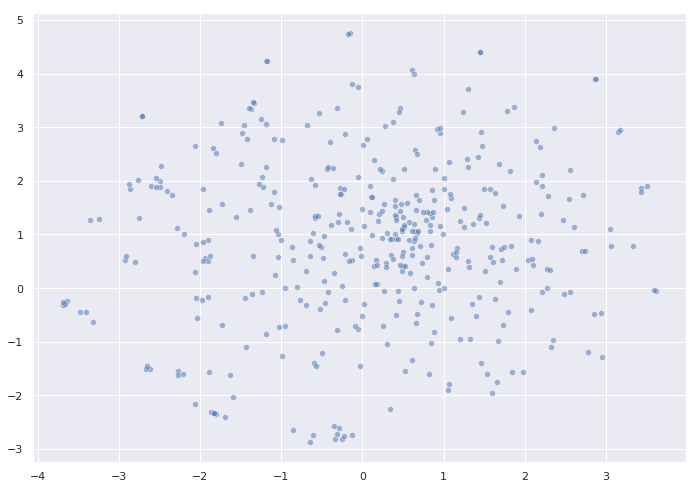

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


In [32]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [33]:
# Preprocess the corpus
corpus = [preprocess(title) for title in text_list]

# Remove docs that don't include any words in W2V's vocab
corpus, text_list = filter_docs(corpus, text_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, text_list = filter_docs(corpus, text_list, lambda doc: (len(doc) != 0))
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

0 docs removed
0 docs removed


ModuleNotFoundError: No module named 'adjustText'

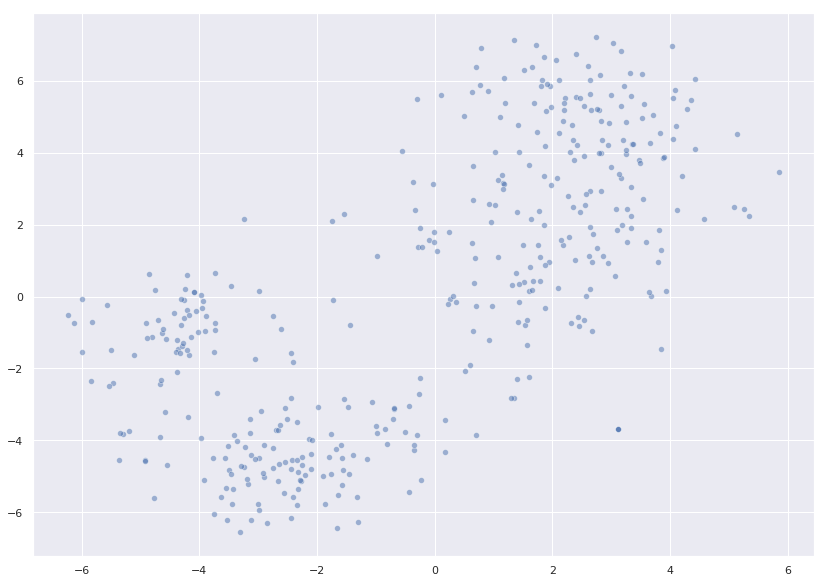

In [34]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


# Commercial Use:Exploration

In [35]:
commuse_dir = '/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/'
filenames = os.listdir(commuse_dir)
print("Number of articles retrieved from Commercial Use:", len(filenames))

Number of articles retrieved from Commercial Use: 9118


In [36]:
all_files = []

for filename in filenames:
    filename = commuse_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)

In [37]:
file = all_files[0]
print("Dictionary keys:", file.keys())

Dictionary keys: dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])


# Commercial Use:Abstract

In [38]:
pprint(file['abstract'])

[{'cite_spans': [],
  'ref_spans': [],
  'section': 'Abstract',
  'text': 'Background: Human rhinoviruses (HRVs) are a highly prevalent cause '
          'of acute respiratory infection in children. They are classified '
          'into at least three species, HRV-A, HRV-B and HRV-C, which are '
          'characterized by sequencing the 59 untranslated region (UTR) or the '
          'VP4/VP2 region of the genome. Given the increased interest for '
          'novel HRV strain identification and their worldwide distribution, '
          'we have carried out clinical and molecular diagnosis of HRV strains '
          'in a 2-year study of children with acute respiratory infection '
          'visiting one district hospital in Shanghai.'},
 {'cite_spans': [],
  'ref_spans': [],
  'section': 'Abstract',
  'text': 'Methodology/Findings: We cloned and sequenced a 924-nt fragment '
          'that covered part of the 59UTR and the VP4/VP2 capsid genes. '
          'Sixty-four HRV-infected ou

# Commercial Use:Body Text

In [39]:
print("body_text type:", type(file['body_text']))
print("body_text length:", len(file['body_text']))
print("body_text keys:", file['body_text'][0].keys())

body_text type: <class 'list'>
body_text length: 28
body_text keys: dict_keys(['text', 'cite_spans', 'ref_spans', 'section'])


In [40]:
print("body_text content:")
pprint(file['body_text'][:2], depth=3)

body_text content:
[{'cite_spans': [{...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...}],
  'ref_spans': [],
  'section': 'Introduction',
  'text': 'Human rhinoviruses (HRVs) are a highly p revalent cause of the '
          'acute respiratory infection (ARI) defined as the common cold [1, 2, '
          '3] , which is frequently associated in children with bronchitis, '
          'bronchiolitis, wheezing, pneumonia, asthma and otitis [4, 5, 6, 7, '
          '8, 9] . HRVs are classified in genus Enterovirus (HEVs) in family '
          'Picornaviridae [10] . HRVs are non-enveloped, single-stranded, '
          'positive-sense RNA viruses of approximately 7200 nt, composed of a '
          '59 untranslated region (UTR), followed by a long open reading frame '
          'coding for capsid proteins VP4, VP2, VP3 and VP1, 

In [41]:
texts = [(di['section'], di['text']) for di in file['body_text']]
texts_di = {di['section']: "" for di in file['body_text']}
for section, text in texts:
    texts_di[section] += text

pprint(list(texts_di.keys()))

['Introduction',
 'Identification and typing by phylogenetic analysis of 66 HRVs in NPSs from '
 'children with ARI',
 'Recombination in the 59 UTR',
 'Comparative analysis of full-length genomes of HRV-A, HRV-B and HRV-C '
 'species',
 'Discussion',
 'Materials and Methods',
 'Specimens and viruses',
 'Multiplex RT-PCR assay',
 'Complete genome sequencing',
 'Nucleotide sequence accession numbers']


In [42]:
body = ""

for section, text in texts_di.items():
    body += section
    body += "\n\n"
    body += text
    body += "\n\n"

print(body[:3000])

Introduction

Human rhinoviruses (HRVs) are a highly p revalent cause of the acute respiratory infection (ARI) defined as the common cold [1, 2, 3] , which is frequently associated in children with bronchitis, bronchiolitis, wheezing, pneumonia, asthma and otitis [4, 5, 6, 7, 8, 9] . HRVs are classified in genus Enterovirus (HEVs) in family Picornaviridae [10] . HRVs are non-enveloped, single-stranded, positive-sense RNA viruses of approximately 7200 nt, composed of a 59 untranslated region (UTR), followed by a long open reading frame coding for capsid proteins VP4, VP2, VP3 and VP1, and seven non-structural proteins 2A, 2B, 2C, 3A, 3B, 3C and 3D, and terminated by a short 39UTR and poly A tract.More than 100 serotypes of HRV are known, which have been classified into two species, HRV-A and HRV-B, according to comparative alignment of nucleotide fragments of VP1 [11, 12] , VP4/VP2 [13] and 59UTR [14, 15] , and more recently, on complete genome nucleotide sequences [16] . Moreover, some

In [43]:
print(format_body(file['body_text'])[:3000])

Introduction

Human rhinoviruses (HRVs) are a highly p revalent cause of the acute respiratory infection (ARI) defined as the common cold [1, 2, 3] , which is frequently associated in children with bronchitis, bronchiolitis, wheezing, pneumonia, asthma and otitis [4, 5, 6, 7, 8, 9] . HRVs are classified in genus Enterovirus (HEVs) in family Picornaviridae [10] . HRVs are non-enveloped, single-stranded, positive-sense RNA viruses of approximately 7200 nt, composed of a 59 untranslated region (UTR), followed by a long open reading frame coding for capsid proteins VP4, VP2, VP3 and VP1, and seven non-structural proteins 2A, 2B, 2C, 3A, 3B, 3C and 3D, and terminated by a short 39UTR and poly A tract.More than 100 serotypes of HRV are known, which have been classified into two species, HRV-A and HRV-B, according to comparative alignment of nucleotide fragments of VP1 [11, 12] , VP4/VP2 [13] and 59UTR [14, 15] , and more recently, on complete genome nucleotide sequences [16] . Moreover, some

# Commercial Use:MetaData

In [44]:
print(all_files[0]['metadata'].keys())

dict_keys(['title', 'authors'])


In [45]:
print(all_files[0]['metadata']['title'])

Evidence of Recombination and Genetic Diversity in Human Rhinoviruses in Children with Acute Respiratory Infection


In [46]:
authors = all_files[0]['metadata']['authors']
pprint(authors[:3])

[{'affiliation': {'institution': 'Unit of Emerging Viruses',
                  'laboratory': '',
                  'location': {'country': "People's Republic of China",
                               'settlement': 'Shanghai'}},
  'email': '',
  'first': 'Ting',
  'last': 'Huang',
  'middle': [],
  'suffix': ''},
 {'affiliation': {'institution': 'Unit of Emerging Viruses',
                  'laboratory': '',
                  'location': {'country': "People's Republic of China",
                               'settlement': 'Shanghai'}},
  'email': '',
  'first': 'Wei',
  'last': 'Wang',
  'middle': [],
  'suffix': ''},
 {'affiliation': {'institution': '',
                  'laboratory': 'Institut Pasteur, Unit of Biology of Enteric '
                                'Viruses',
                  'location': {'country': 'France', 'settlement': 'Paris'}},
  'email': '',
  'first': 'Mael',
  'last': 'Bessaud',
  'middle': [],
  'suffix': ''}]


In [47]:
for author in authors:
    print("Name:", format_name(author))
    print("Affiliation:", format_affiliation(author['affiliation']))
    print()

Name: Ting Huang
Affiliation: Unit of Emerging Viruses, Shanghai, People's Republic of China

Name: Wei Wang
Affiliation: Unit of Emerging Viruses, Shanghai, People's Republic of China

Name: Mael Bessaud
Affiliation: Paris, France

Name: Peijun Ren
Affiliation: Unit of Emerging Viruses, Shanghai, People's Republic of China

Name: Jun Sheng
Affiliation: Shanghai Nanxiang Hospital, Shanghai, People's Republic of China

Name: Huajie Yan
Affiliation: Shanghai Nanxiang Hospital, Shanghai, People's Republic of China

Name: Jing Zhang
Affiliation: Unit of Emerging Viruses, Shanghai, People's Republic of China

Name: Xin Lin
Affiliation: Unit of Emerging Viruses, Shanghai, People's Republic of China

Name: Yongjin Wang
Affiliation: Unit of Emerging Viruses, Shanghai, People's Republic of China

Name: Francis Delpeyroux
Affiliation: Paris, France

Name: Vincent Deubel
Affiliation: Unit of Emerging Viruses, Shanghai, People's Republic of China



In [48]:
pprint(all_files[4]['metadata'], depth=4)

{'authors': [{'affiliation': {},
              'email': '',
              'first': 'Danila',
              'last': 'Vella',
              'middle': [],
              'suffix': ''},
             {'affiliation': {},
              'email': '',
              'first': 'Italo',
              'last': 'Zoppis',
              'middle': [],
              'suffix': ''},
             {'affiliation': {},
              'email': '',
              'first': 'Giancarlo',
              'last': 'Mauri',
              'middle': [],
              'suffix': ''},
             {'affiliation': {},
              'email': '',
              'first': 'Pierluigi',
              'last': 'Mauri',
              'middle': [],
              'suffix': ''},
             {'affiliation': {},
              'email': '',
              'first': 'Dario',
              'last': 'Silvestre',
              'middle': ['Di'],
              'suffix': ''}],
 'title': 'From protein-protein interactions to protein co-expression '
         

In [49]:
authors = all_files[4]['metadata']['authors']
print("Formatting without affiliation:")
print(format_authors(authors, with_affiliation=False))
print("\nFormatting with affiliation:")
print(format_authors(authors, with_affiliation=True))

Formatting without affiliation:
Danila Vella, Italo Zoppis, Giancarlo Mauri, Pierluigi Mauri, Dario Di Silvestre

Formatting with affiliation:
Danila Vella, Italo Zoppis, Giancarlo Mauri, Pierluigi Mauri, Dario Di Silvestre


# Commercial Use:Bibliography

In [50]:
bibs = list(file['bib_entries'].values())
pprint(bibs[:2], depth=4)

[{'authors': [{'first': 'F', 'last': 'Hayden', 'middle': [...], 'suffix': ''}],
  'issn': '',
  'other_ids': {},
  'pages': '17--31',
  'ref_id': 'b0',
  'title': 'Rhinovirus and the lower respiratory tract',
  'venue': 'Rev Med Virol',
  'volume': '14',
  'year': 2004},
 {'authors': [{'first': 'T', 'last': 'Heikkinen', 'middle': [], 'suffix': ''},
              {'first': 'A', 'last': 'Jarvinen', 'middle': [], 'suffix': ''}],
  'issn': '',
  'other_ids': {},
  'pages': '51--59',
  'ref_id': 'b1',
  'title': 'The common cold',
  'venue': 'Lancet',
  'volume': '361',
  'year': 2003}]


In [51]:
format_authors(bibs[1]['authors'], with_affiliation=False)

'T Heikkinen, A Jarvinen'

In [52]:
bib_formatted = format_bib(bibs[:5])
print(bib_formatted)

Rhinovirus and the lower respiratory tract, F G Hayden, Rev Med Virol, 2004; The common cold, T Heikkinen, A Jarvinen, Lancet, 2003; Human rhinoviruses: the cold wars resume, I M Mackay, J Clin Virol, 2008; New developments in the epidemiology and clinical spectrum of rhinovirus infections, J W Brownlee, R B Turner, Curr Opin Pediatr, 2008; Association of respiratory picornaviruses with acute bronchiolitis in French infants, J Jacques, M Bouscambert-Duchamp, H Moret, J Carquin, V Brodard, J Clin Virol, 2006


# Commercial Use:Generate CSV

In [53]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        format_body(file['abstract']),
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)

In [54]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

commuse_df = pd.DataFrame(cleaned_files, columns=col_names)
commuse_df.head()

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,8d095d0275e474dbb9d9b63a75591ff2c0667d73,Evidence of Recombination and Genetic Diversit...,"Ting Huang, Wei Wang, Mael Bessaud, Peijun Ren...","Ting Huang (Unit of Emerging Viruses, Shanghai...",Abstract\n\nBackground: Human rhinoviruses (HR...,Introduction\n\nHuman rhinoviruses (HRVs) are ...,"Rhinovirus and the lower respiratory tract, F ...","[{'first': 'Ting', 'middle': [], 'last': 'Huan...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Rhinovi..."
1,43918c75d7b7d3f9402b1342dfea1e19eb2bd909,Antibacterial Properties of Visible-Light-Resp...,"Der-Shan Sun, Jyh-Hwa Kau, Hsin-Hsien Huang, Y...","Der-Shan Sun (Tzu-Chi University, 97004, Huali...",Abstract\n\nThe bactericidal activity of conve...,Introduction\n\nAnthrax is a life-threatening ...,"Anthrax in humans and animals, , Anthrax in Hu...","[{'first': 'Der-Shan', 'middle': [], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Anthrax..."
2,daaa53a49dc0d23015e22a150495ac657aa993d8,Transcriptional and Translational Landscape of...,"Hazel Stewart, Katherine Brown, Adam M Dinan, ...","Hazel Stewart (University of Cambridge, Cambri...",Abstract\n\nThe genus Torovirus (subfamily Tor...,"\n\ncattle, goats, sheep, pigs, and horses, ca...",Mesoniviridae: a proposed new family in the or...,"[{'first': 'Hazel', 'middle': [], 'last': 'Ste...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Mesoniv..."
3,a8fb2e52e4545f4de90bc13e44ae914d9da6a8ab,Patient Isolation Precautions: Are They Worth It?,"Elliott Sprague, Steven Reynolds, Peter Brindley","Elliott Sprague (University of Alberta, T6G 2B...",Abstract\n\nIsolation precautions are intended...,Introduction\n\nIsolation precautions (IPs) ar...,Hospital epidemiology and infection control in...,"[{'first': 'Elliott', 'middle': [], 'last': 'S...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Hospita..."
4,f501b5ccc17158a3018dc5688b253e31ba0380d5,From protein-protein interactions to protein c...,"Danila Vella, Italo Zoppis, Giancarlo Mauri, P...","Danila Vella, Italo Zoppis, Giancarlo Mauri, P...",Abstract\n\nThe reductionist approach of disse...,Introduction\n\nThe development of systems bio...,"Structural bioinformatics of the interactome, ...","[{'first': 'Danila', 'middle': [], 'last': 'Ve...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Structu..."


# Custom License:Exploration

In [55]:
customlicense_dir = '/kaggle/input/CORD-19-research-challenge/custom_license/custom_license/'
filenames = os.listdir(customlicense_dir)
print("Number of articles retrieved from Commercial Use:", len(filenames))

Number of articles retrieved from Commercial Use: 16959


In [56]:
all_files = []

for filename in filenames:
    filename = customlicense_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)

In [57]:
file = all_files[0]
print("Dictionary keys:", file.keys())

Dictionary keys: dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])


# Custom License:Abstract

In [58]:
pprint(file['abstract'])

[{'cite_spans': [],
  'ref_spans': [],
  'section': 'Abstract',
  'text': 'The objective of this study was to evaluate the benefits of '
          'supplementation of mannan oligosaccharide (MOS) to cows during the '
          'last 3 wk of the dry period on immune function of the cows and '
          'subsequent transfer of passive immunity to their calves. Indicators '
          'of nonspecific and specific immunity were evaluated. Cows were '
          'vaccinated against rotavirus at 4 and 2 wk before expected '
          'parturition. Blood samples were obtained from cows before '
          'vaccination and at weekly intervals until calving and from calves '
          'at birth and 24 h for analysis of serum protein concentrations, '
          'packed cell volume, white blood cell counts, white blood cell '
          'differentials, and serum rotavirus neutralization titers. Colostrum '
          'quantity and quality were measured at calving, and immunoglobulin '
          'isoty

# Custom License:Body Text

In [59]:
print("body_text type:", type(file['body_text']))
print("body_text length:", len(file['body_text']))
print("body_text keys:", file['body_text'][0].keys())

body_text type: <class 'list'>
body_text length: 40
body_text keys: dict_keys(['text', 'cite_spans', 'ref_spans', 'section'])


In [60]:
print("body_text content:")
pprint(file['body_text'][:2], depth=3)

body_text content:
[{'cite_spans': [{...}, {...}, {...}, {...}, {...}],
  'ref_spans': [],
  'section': 'INTRODUCTION',
  'text': 'The periparturient period is an extremely important time for dairy '
          'cows and the offspring they are carrying. During the 3 to 4 wk '
          'before parturition, cows are not only challenged by exposure to '
          'diseases, but they also must transfer Ig from serum into colostrum '
          'to provide immunity for their calves. Unfortunately, the immune '
          'system of dairy cows becomes depressed during the periparturient '
          'period (Kehrli et al., 1989a, b) , causing them to be less able to '
          'respond to challenges (Cai et al., 1994) . In addition, sufficient '
          'passive transfer of immunity to the calf may be jeopardized if cows '
          'are not able to transfer enough Ig into colostrum to provide '
          'adequate colostrum quality (Stott and Fellah, 1983; Rea et al., '
          '1996) . F

In [61]:
texts = [(di['section'], di['text']) for di in file['body_text']]
texts_di = {di['section']: "" for di in file['body_text']}
for section, text in texts:
    texts_di[section] += text

pprint(list(texts_di.keys()))

['INTRODUCTION',
 'Animals and Animal Procedures',
 'Sample Analysis',
 'Statistical Analysis',
 'Parameters for Dams',
 'Figure 2.',
 'Parameters for Colostrum',
 'Parameters for Calves',
 'DISCUSSION',
 'CONCLUSIONS']


In [62]:
body = ""

for section, text in texts_di.items():
    body += section
    body += "\n\n"
    body += text
    body += "\n\n"

print(body[:3000])

INTRODUCTION

The periparturient period is an extremely important time for dairy cows and the offspring they are carrying. During the 3 to 4 wk before parturition, cows are not only challenged by exposure to diseases, but they also must transfer Ig from serum into colostrum to provide immunity for their calves. Unfortunately, the immune system of dairy cows becomes depressed during the periparturient period (Kehrli et al., 1989a, b) , causing them to be less able to respond to challenges (Cai et al., 1994) . In addition, sufficient passive transfer of immunity to the calf may be jeopardized if cows are not able to transfer enough Ig into colostrum to provide adequate colostrum quality (Stott and Fellah, 1983; Rea et al., 1996) . For instance, Perino et al. (1995) reported that calves born to dams with mastitis had lower plasma protein and IgG concentrations at 10 and 24 h after birth compared with calves born to dams without mastitis.Diseases such as mastitis in periparturient cows and

In [63]:
print(format_body(file['body_text'])[:3000])

INTRODUCTION

The periparturient period is an extremely important time for dairy cows and the offspring they are carrying. During the 3 to 4 wk before parturition, cows are not only challenged by exposure to diseases, but they also must transfer Ig from serum into colostrum to provide immunity for their calves. Unfortunately, the immune system of dairy cows becomes depressed during the periparturient period (Kehrli et al., 1989a, b) , causing them to be less able to respond to challenges (Cai et al., 1994) . In addition, sufficient passive transfer of immunity to the calf may be jeopardized if cows are not able to transfer enough Ig into colostrum to provide adequate colostrum quality (Stott and Fellah, 1983; Rea et al., 1996) . For instance, Perino et al. (1995) reported that calves born to dams with mastitis had lower plasma protein and IgG concentrations at 10 and 24 h after birth compared with calves born to dams without mastitis.Diseases such as mastitis in periparturient cows and

# Custom License:Metadata

In [64]:
print(all_files[0]['metadata'].keys())

dict_keys(['title', 'authors'])


In [65]:
print(all_files[0]['metadata']['title'])

Immune Parameters of Dry Cows Fed Mannan Oligosaccharide and Subsequent Transfer of Immunity to Calves*


In [66]:
authors = all_files[0]['metadata']['authors']
pprint(authors[:3])

[{'affiliation': {'institution': 'University of Kentucky',
                  'laboratory': '',
                  'location': {'postCode': '40546-0215',
                               'settlement': 'Lexington'}},
  'email': '',
  'first': 'S',
  'last': 'Franklin',
  'middle': ['T'],
  'suffix': ''},
 {'affiliation': {'institution': 'University of Kentucky',
                  'laboratory': '',
                  'location': {'postCode': '40546-0215',
                               'settlement': 'Lexington'}},
  'email': '',
  'first': 'M',
  'last': 'Newman',
  'middle': ['C'],
  'suffix': ''},
 {'affiliation': {'institution': 'Venture Laboratories, Inc. Lexington',
                  'laboratory': '',
                  'location': {'postCode': '40511', 'region': 'Kentucky'}},
  'email': '',
  'first': 'K',
  'last': 'Newman',
  'middle': ['E'],
  'suffix': ''}]


In [67]:
for author in authors:
    print("Name:", format_name(author))
    print("Affiliation:", format_affiliation(author['affiliation']))
    print()

Name: S T Franklin
Affiliation: University of Kentucky, 40546-0215, Lexington

Name: M C Newman
Affiliation: University of Kentucky, 40546-0215, Lexington

Name: K E Newman
Affiliation: Venture Laboratories, Inc. Lexington, 40511, Kentucky

Name: K I Meek
Affiliation: University of Kentucky, 40546-0215, Lexington



In [68]:
pprint(all_files[4]['metadata'], depth=4)

{'authors': [{'affiliation': {'institution': 'Hospital Universitario Virgen '
                                             'del Rocío',
                              'laboratory': '',
                              'location': {...}},
              'email': '',
              'first': 'A',
              'last': 'Díaz',
              'middle': [],
              'suffix': ''},
             {'affiliation': {'institution': 'Hospital Universitario Dr. Peset',
                              'laboratory': '',
                              'location': {...}},
              'email': '',
              'first': 'R',
              'last': 'Zaragoza',
              'middle': [],
              'suffix': ''},
             {'affiliation': {'institution': 'Hospital Universitario de '
                                             "Bellvitge, L'Hospitalet de "
                                             'Llobregat',
                              'laboratory': '',
                              'location': {.

In [69]:
authors = all_files[4]['metadata']['authors']
print("Formatting without affiliation:")
print(format_authors(authors, with_affiliation=False))
print("\nFormatting with affiliation:")
print(format_authors(authors, with_affiliation=True))

Formatting without affiliation:
A Díaz, R Zaragoza, R Granada, M Salavert

Formatting with affiliation:
A Díaz (Hospital Universitario Virgen del Rocío, Sevilla, España), R Zaragoza (Hospital Universitario Dr. Peset, Valencia, España), R Granada (Hospital Universitario de Bellvitge, L'Hospitalet de Llobregat, Barcelona, España), M Salavert (Unidad de Enfermedades Infecciosas, Hospital Universitario La Fe, Valencia, España)


# Custom License:Bibliography

In [70]:
bibs = list(file['bib_entries'].values())
pprint(bibs[:2], depth=4)

[{'authors': [{'first': 'D', 'last': 'Archambault', 'middle': [], 'suffix': ''},
              {'first': 'G', 'last': 'Morin', 'middle': [], 'suffix': ''},
              {'first': 'Y', 'last': 'Elazhary', 'middle': [], 'suffix': ''},
              {'first': 'R', 'last': 'Roy', 'middle': [...], 'suffix': ''},
              {'first': 'J', 'last': 'Joncas', 'middle': [...], 'suffix': ''}],
  'issn': '',
  'other_ids': {},
  'pages': '1084--1091',
  'ref_id': 'b0',
  'title': 'Immune response of pregnant heifers and cows to bovine rotavirus '
           'inoculation and passive protection to rotavirus infection in '
           'newborn calves fed colostral antibodies or colostral lymphocytes',
  'venue': 'Am. J. Vet. Res',
  'volume': '49',
  'year': 1988},
 {'authors': [{'first': 'G',
               'last': 'Barrington',
               'middle': [...],
               'suffix': ''},
              {'first': 'T', 'last': 'Besser', 'middle': [...], 'suffix': ''},
              {'first': 'W', 

In [71]:
format_authors(bibs[1]['authors'], with_affiliation=False)

'G M Barrington, T E Besser, W C Davis, C C Gay, J J Reeves, T B Mcfadden'

In [72]:
bib_formatted = format_bib(bibs[:5])
print(bib_formatted)

Immune response of pregnant heifers and cows to bovine rotavirus inoculation and passive protection to rotavirus infection in newborn calves fed colostral antibodies or colostral lymphocytes, D Archambault, G Morin, Y Elazhary, R S Roy, J H Joncas, Am. J. Vet. Res, 1988; Expression of immunoglobulin G1 receptors by bovine mammary epithelial cells and mammary leukocytes, G M Barrington, T E Besser, W C Davis, C C Gay, J J Reeves, T B Mcfadden, J. Dairy Sci, 1997; Passive immunity to bovine rotavirus infection associated with transfer of serum antibody into the intestinal lumen, T E Besser, C C Gay, T C Mcguire, J F Evermann, J. Virol, 1988; Transfer of functional immunoglobulin G (IgG) antibody into the gastrointestinal tract accounts for IgG clearance in calves, T E Besser, T C Mcguire, C C Gay, L C Pritchett, J. Virol, 1988; Association between neutrophil function and periparturient disorders in cows, T Q Cai, P G Weston, L A Lund, B Brodie, D J Mckenna, W C Wagner, Am. J. Vet. Res, 1

# Custom License:Generate CSV Files.

In [73]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        format_body(file['abstract']),
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)

In [74]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

custom_df = pd.DataFrame(cleaned_files, columns=col_names)
custom_df.head()

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,14572a7a9b3e92b960d92d9755979eb94c448bb5,Immune Parameters of Dry Cows Fed Mannan Oligo...,"S T Franklin, M C Newman, K E Newman, K I Meek","S T Franklin (University of Kentucky, 40546-02...",Abstract\n\nThe objective of this study was to...,INTRODUCTION\n\nThe periparturient period is a...,Immune response of pregnant heifers and cows t...,"[{'first': 'S', 'middle': ['T'], 'last': 'Fran...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Immune ..."
1,bb790e8366da63c4f5e2d64fa7bbd5673b93063c,Discontinuous Transcription or RNA Processing ...,"Beate Schwer, Paolo Vista, Jan C Vos, Hendrik ...","Beate Schwer, Paolo Vista, Jan C Vos, Hendrik ...",,Discontinuous\n\nTranscription or RNA Processi...,Poly (riboadenylic acid) preferentially inhibi...,"[{'first': 'Beate', 'middle': [], 'last': 'Sch...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Poly (r..."
2,24f204ce5a1a4d752dc9ea7525082d225caed8b3,,,,,Letter to the Editor\n\nThe non-contact handhe...,Novel coronavirus is putting the whole world o...,[],"{'BIBREF0': {'ref_id': 'b0', 'title': 'Novel c..."
3,ab78a42c688ac199a2d5669e42ee4c39ff0df2b8,A real-time convective PCR machine in a capill...,"Yi-Fan Hsieh, Da-Sheng Lee, Ping-Hei Chen, Sha...","Yi-Fan Hsieh (National Taiwan University, 106,...","Abstract\n\nThis research reports the design, ...",Introduction\n\nMullis et al. developed the po...,"The Polymerase Chain Reaction, K B Mullis, F F...","[{'first': 'Yi-Fan', 'middle': [], 'last': 'Hs...","{'BIBREF0': {'ref_id': 'b0', 'title': 'The Pol..."
4,31105078a2953217223699d09c6a80d0f5edfdf6,Infecciones virales graves en pacientes inmuno...,"A Díaz, R Zaragoza, R Granada, M Salavert",A Díaz (Hospital Universitario Virgen del Rocí...,Abstract\n\nRecibido el 21 de diciembre de 201...,"\n\nFurthermore, ventilator-associated pneumon...",High prevalence of respiratory viral infecions...,"[{'first': 'A', 'middle': [], 'last': 'Díaz', ...","{'BIBREF0': {'ref_id': 'b0', 'title': 'High pr..."


# Non Commercial Use:Exploration

In [75]:
noncommuse_dir = '/kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/'
filenames = os.listdir(noncommuse_dir)
print("Number of articles retrieved from Commercial Use:", len(filenames))

Number of articles retrieved from Commercial Use: 2353


In [76]:
all_files = []

for filename in filenames:
    filename = noncommuse_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)

In [77]:
file = all_files[0]
print("Dictionary keys:", file.keys())

Dictionary keys: dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])


# Non Commercial Use:Abstract

In [78]:
pprint(file['abstract'])

[{'cite_spans': [],
  'ref_spans': [],
  'section': 'Abstract',
  'text': 'Mesenchymal stem cells have been widely studied to promote local '
          'bone regeneration of osteonecrosis of the femoral head (ONFH). '
          'Previous studies observed that dimethyloxaloylglycine (DMOG) '
          'enhanced the angiogenic and osteogenic activity of mesenchymal stem '
          'cells by activating the expression of hypoxia inducible factor-1α '
          '(HIF-1α), thereby improving the bone repair capacity of mesenchymal '
          'stem cells. In the present study, it was investigated whether DMOG '
          'could increase the bone repair capacity of adipose-derived stem '
          'cells (ASCs) in the treatment of ONFH. Western blot analysis was '
          'performed to detect HIF-1α protein expression in ASCs treated with '
          'different concentrations of DMOG. The results showed DMOG enhanced '
          'HIF-1α expression in ASCs in a dose-dependent manner at least

# Non Commercial Use:Body Text

In [79]:
print("body_text type:", type(file['body_text']))
print("body_text length:", len(file['body_text']))
print("body_text keys:", file['body_text'][0].keys())

body_text type: <class 'list'>
body_text length: 28
body_text keys: dict_keys(['text', 'cite_spans', 'ref_spans', 'section'])


In [80]:
print("body_text content:")
pprint(file['body_text'][:2], depth=3)

body_text content:
[{'cite_spans': [{...}, {...}, {...}, {...}],
  'ref_spans': [],
  'section': 'Introduction',
  'text': 'Osteonecrosis of the femoral head (ONFH) is a pathological process '
          'primarily caused by interrupted local blood circulation, which can '
          'cause apoptosis of osteocytes and osseous tissue necrosis (1, 2) . '
          'The lack of effective therapy for ONFH is a difficulty that needs '
          'to be overcome in clinical practice. Several methods have been used '
          'to treat early-stage ONFH, such as drug therapy, core '
          'decompression, vascularized bone grafting and rotational osteotomy. '
          'However, the clinical results of these methods are not satisfactory '
          '(3, 4) .'},
 {'cite_spans': [{...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {...},
                 {.

In [81]:
texts = [(di['section'], di['text']) for di in file['body_text']]
texts_di = {di['section']: "" for di in file['body_text']}
for section, text in texts:
    texts_di[section] += text

pprint(list(texts_di.keys()))

['Introduction',
 'Materials and methods',
 'Micro-computed tomography (CT) scanning.',
 'Results',
 'Assessment of bone regeneration in the necrotic area.',
 'Assessment of neovascularization in the necrotic area.',
 'HIF-1α expression in ASCs in vivo.',
 'Discussion']


In [82]:
body = ""

for section, text in texts_di.items():
    body += section
    body += "\n\n"
    body += text
    body += "\n\n"

print(body[:3000])

Introduction

Osteonecrosis of the femoral head (ONFH) is a pathological process primarily caused by interrupted local blood circulation, which can cause apoptosis of osteocytes and osseous tissue necrosis (1, 2) . The lack of effective therapy for ONFH is a difficulty that needs to be overcome in clinical practice. Several methods have been used to treat early-stage ONFH, such as drug therapy, core decompression, vascularized bone grafting and rotational osteotomy. However, the clinical results of these methods are not satisfactory (3, 4) .Previous studies have described the use of mesenchymal stem cells (MSCs) to promote local bone repair and healing (5, 6) . MSCs are pluripotent and can differentiate into several lineages of cells, which have shown potency in the treatment of numerous ischemic diseases, such as myocardial infarction (7, 8) , nerve injury (9) and bone defect (10) . Prior studies have found that the implantation of MSCs into the necrotic area of the femoral head was a

In [83]:
print(format_body(file['body_text'])[:3000])

Introduction

Osteonecrosis of the femoral head (ONFH) is a pathological process primarily caused by interrupted local blood circulation, which can cause apoptosis of osteocytes and osseous tissue necrosis (1, 2) . The lack of effective therapy for ONFH is a difficulty that needs to be overcome in clinical practice. Several methods have been used to treat early-stage ONFH, such as drug therapy, core decompression, vascularized bone grafting and rotational osteotomy. However, the clinical results of these methods are not satisfactory (3, 4) .Previous studies have described the use of mesenchymal stem cells (MSCs) to promote local bone repair and healing (5, 6) . MSCs are pluripotent and can differentiate into several lineages of cells, which have shown potency in the treatment of numerous ischemic diseases, such as myocardial infarction (7, 8) , nerve injury (9) and bone defect (10) . Prior studies have found that the implantation of MSCs into the necrotic area of the femoral head was a

# Non Commercial Use:Metadata

In [84]:
print(all_files[0]['metadata'].keys())

dict_keys(['title', 'authors'])


In [85]:
print(all_files[0]['metadata']['title'])

EXPERIMENTAL AND THERAPEUTIC MEDICINE Dimethyloxaloylglycine increases bone repair capacity of adipose-derived stem cells in the treatment of osteonecrosis of the femoral head


In [86]:
authors = all_files[0]['metadata']['authors']
pprint(authors[:3])

[{'affiliation': {'institution': 'Shanghai Jiao Tong University',
                  'laboratory': '',
                  'location': {'country': 'P.R. China',
                               'postCode': '200233',
                               'settlement': 'Shanghai'}},
  'email': '',
  'first': 'Zhen-Hong',
  'last': 'Zhu',
  'middle': [],
  'suffix': ''},
 {'affiliation': {'institution': 'Shanghai Jiao Tong University',
                  'laboratory': '',
                  'location': {'country': 'P.R. China',
                               'postCode': '200233',
                               'settlement': 'Shanghai'}},
  'email': '',
  'first': 'Wen-Qi',
  'last': 'Song',
  'middle': [],
  'suffix': ''},
 {'affiliation': {'institution': 'Shanghai Jiao Tong University',
                  'laboratory': '',
                  'location': {'country': 'P.R. China',
                               'postCode': '200233',
                               'settlement': 'Shanghai'}},
  'email': '',

In [87]:
for author in authors:
    print("Name:", format_name(author))
    print("Affiliation:", format_affiliation(author['affiliation']))
    print()

Name: Zhen-Hong Zhu
Affiliation: Shanghai Jiao Tong University, 200233, Shanghai, P.R. China

Name: Wen-Qi Song
Affiliation: Shanghai Jiao Tong University, 200233, Shanghai, P.R. China

Name: Chang-Qing Zhang
Affiliation: Shanghai Jiao Tong University, 200233, Shanghai, P.R. China

Name: Ji-Min Yin
Affiliation: Jiao Tong University, 600 Yishan Road, 200233, Shanghai, P.R. China



In [88]:
pprint(all_files[4]['metadata'], depth=4)

{'authors': [{'affiliation': {'institution': 'Johns Hopkins Bloomberg School '
                                             'of Public Health',
                              'laboratory': '',
                              'location': {...}},
              'email': '',
              'first': 'Stacey',
              'last': 'Burgess',
              'middle': ['L'],
              'suffix': ''},
             {'affiliation': {'institution': 'Johns Hopkins Bloomberg School '
                                             'of Public Health',
                              'laboratory': '',
                              'location': {...}},
              'email': '',
              'first': 'Erica',
              'last': 'Buonomo',
              'middle': [],
              'suffix': ''},
             {'affiliation': {'institution': 'Johns Hopkins Bloomberg School '
                                             'of Public Health',
                              'laboratory': '',
                      

In [89]:
authors = all_files[4]['metadata']['authors']
print("Formatting without affiliation:")
print(format_authors(authors, with_affiliation=False))
print("\nFormatting with affiliation:")
print(format_authors(authors, with_affiliation=True))

Formatting without affiliation:
Stacey L Burgess, Erica Buonomo, Maureen Carey, Carrie Cowardin, Caitlin Naylor, Zannatun Noor, Marsha Wills-Karp, William A Petri, Burgess Sl, Buonomo E , Carey M Cowardin, C , Naylor C , Noor Z Wills-Karp M,  Petri

Formatting with affiliation:
Stacey L Burgess (Johns Hopkins Bloomberg School of Public Health, Baltimore, Maryland, USA), Erica Buonomo (Johns Hopkins Bloomberg School of Public Health, Baltimore, Maryland, USA), Maureen Carey (Johns Hopkins Bloomberg School of Public Health, Baltimore, Maryland, USA), Carrie Cowardin (Johns Hopkins Bloomberg School of Public Health, Baltimore, Maryland, USA), Caitlin Naylor (Johns Hopkins Bloomberg School of Public Health, Baltimore, Maryland, USA), Zannatun Noor (Johns Hopkins Bloomberg School of Public Health, Baltimore, Maryland, USA), Marsha Wills-Karp, William A Petri (Johns Hopkins Bloomberg School of Public Health, Baltimore, Maryland, USA), Burgess Sl, Buonomo E , Carey M Cowardin, C , Naylor C , 

# Non commercial use:Bibliography

In [90]:
bibs = list(file['bib_entries'].values())
pprint(bibs[:2], depth=4)

[{'authors': [{'first': 'M',
               'last': 'Kerachian',
               'middle': [...],
               'suffix': ''},
              {'first': 'E', 'last': 'Harvey', 'middle': [...], 'suffix': ''},
              {'first': 'D', 'last': 'Cournoyer', 'middle': [], 'suffix': ''},
              {'first': 'T', 'last': 'Chow', 'middle': [...], 'suffix': ''},
              {'first': 'C', 'last': 'Séguin', 'middle': [], 'suffix': ''}],
  'issn': '',
  'other_ids': {},
  'pages': '237--244',
  'ref_id': 'b0',
  'title': 'Avascular necrosis of the femoral head: Vascular hypotheses',
  'venue': 'Endothelium',
  'volume': '13',
  'year': 2006},
 {'authors': [{'first': 'F',
               'last': 'Bachiller',
               'middle': [...],
               'suffix': ''},
              {'first': 'A', 'last': 'Caballer', 'middle': [...], 'suffix': ''},
              {'first': 'L', 'last': 'Portal', 'middle': [...], 'suffix': ''}],
  'issn': '',
  'other_ids': {},
  'pages': '87--109',
  'ref_id

In [91]:
format_authors(bibs[1]['authors'], with_affiliation=False)

'F G Bachiller, A P Caballer, L F Portal'

In [92]:
bib_formatted = format_bib(bibs[:5])
print(bib_formatted)

Avascular necrosis of the femoral head: Vascular hypotheses, M A Kerachian, E J Harvey, D Cournoyer, T Y Chow, C Séguin, Endothelium, 2006; Avascular necrosis of the femoral head after femoral neck fracture, F G Bachiller, A P Caballer, L F Portal, Clin Orthop Relat Res, 2002; Osteonecrosis of the hip: Management in the 21st century, J R Lieberman, D J Berry, M A Mont, R K Aaron, J J Callaghan, A D Rajadhyaksha, J R Urbaniak, Instr Course Lect, 2003; Failure after core decompression in osteonecrosis of the femoral head, T R Yoon, E K Song, Rowe Sm, C H Park, Int Orthop, 2001; Repair of canine mandibular bone defects with bone marrow stromal cells and porous beta-tricalcium phosphate, J Yuan, L Cui, W J Zhang, W Liu, Y Cao, Biomaterials, 2007


# Non Commercial Use:Generate CSV files

In [93]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        format_body(file['abstract']),
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)

In [94]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

noncom_df = pd.DataFrame(cleaned_files, columns=col_names)
noncom_df.head()

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,cd92f91038067e7a10aa27d676ce696e1e4d67ce,EXPERIMENTAL AND THERAPEUTIC MEDICINE Dimethyl...,"Zhen-Hong Zhu, Wen-Qi Song, Chang-Qing Zhang, ...","Zhen-Hong Zhu (Shanghai Jiao Tong University, ...",Abstract\n\nMesenchymal stem cells have been w...,Introduction\n\nOsteonecrosis of the femoral h...,Avascular necrosis of the femoral head: Vascul...,"[{'first': 'Zhen-Hong', 'middle': [], 'last': ...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Avascul..."
1,bab279da548d8bd363acd5033e9dc54e7dbb7107,Effects of school breaks on influenza- like il...,"Yanhui Chu, Zhenyu Wu, Jiayi Ji, Jingyi Sun, X...","Yanhui Chu, Zhenyu Wu (Fudan University, Shang...",,INTRODUCTION\n\nSchoolchildren play a major ro...,Estimating household and community transmissio...,"[{'first': 'Yanhui', 'middle': [], 'last': 'Ch...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Estimat..."
2,71edbd57cdd9af956a12054932e0cbdb87ce1fea,Social Network Characteristics and Body Mass I...,"Won Joon Lee, Yoosik Youm, Yumie Rhee, Yeong-R...",Won Joon Lee (Yonsei University College of Med...,Abstract\n\nResearch has shown that obesity ap...,INTRODUCTION\n\nThe study of the effects of so...,The contribution of the social environment to ...,"[{'first': 'Won', 'middle': ['Joon'], 'last': ...","{'BIBREF0': {'ref_id': 'b0', 'title': 'The con..."
3,2dfdbf2d6b77426866feaf93486327d372fd27c7,CLINICAL EXPERIMENTAL VACCINE RESEARCH,,,,\n\nThere may be many reasons for the signific...,"A short history of vaccination, S L Plotkin, S...",[],"{'BIBREF0': {'ref_id': 'b0', 'title': 'A short..."
4,0afa3ea846396533c7ca515968abcfea3f895082,Bone Marrow Dendritic Cells from Mice with an ...,"Stacey L Burgess, Erica Buonomo, Maureen Carey...",Stacey L Burgess (Johns Hopkins Bloomberg Scho...,Abstract\n\nThere is an emerging paradigm that...,\n\nport neutrophil infiltration in inflammato...,WHO/PAHO informal consultation on intestinal p...,"[{'first': 'Stacey', 'middle': ['L'], 'last': ...","{'BIBREF0': {'ref_id': 'b0', 'title': 'WHO/PAH..."
